In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
def conv_block(tensor_in, filters, kernel_size, repeats=2, pool_strides=(2, 2), block_id=1):
    x = tensor_in
    for i in range(repeats):
        conv_name = f'block{block_id}_conv{i + 1}'
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', name=conv_name)(x)

    x = MaxPooling2D((2, 2), strides=pool_strides, name=f'block{block_id}_pool')(x)
    return x

In [36]:
def create_vggnet(input_shape=(224, 224, 3), n_classes=2):
    input_tensor = Input(shape=input_shape, name='input')
    x = conv_block(input_tensor, filters=64, kernel_size=(3, 3), repeats=2, pool_strides=(2, 2), block_id=1)
    x = conv_block(x, filters=128, kernel_size=(3, 3), repeats=2, pool_strides=(2, 2), block_id=2)
    x = conv_block(x, filters=256, kernel_size=(3, 3), repeats=3, pool_strides=(2, 2), block_id=3)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5, name='dropout_1')(x)
    x = Dense(units=120, activation='relu', name='fc_1')(x)
    x = Dropout(0.5, name='dropout_2')(x)

    output = Dense(units=n_classes, activation='sigmoid', name='output')(x)
    return Model(inputs=input_tensor, outputs=output, name='vggnet_light')

In [4]:
from models.utils.image_handler import ImageHandler

img_srcs = [
    '/Users/jiheo/Desktop/workspace/datasets/cpfd/images/clean_door/open',
    '/Users/jiheo/Desktop/workspace/datasets/cpfd/images/clean_door/closed',
]

classes = [0, 1]

img_handler = ImageHandler(src_dirs=img_srcs, classes=classes, batch_size=32)

[INFO] reading src `/Users/jiheo/Desktop/workspace/datasets/cpfd/images/clean_door/open`
[INFO] reading src `/Users/jiheo/Desktop/workspace/datasets/cpfd/images/clean_door/closed`
[INFO] finished reading images: len of images 2000, len of labels 2000
image shape: (2000, 224, 224, 3)
label shape: (2000,)
[INFO] scaling images
[INFO] train_images, train_labels, test_images, test_labels splitted
[INFO] each shape: (1500, 224, 224, 3), (1500, 2), (500, 224, 224, 3), (500, 2)


In [37]:
model = create_vggnet(input_shape=(224, 224, 3), n_classes=2)
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('../../model_weights/vgg_weights.hdf5')

Model: "vggnet_light"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# Training model
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(
    img_handler.train_ds,
    epochs=20,
    validation_data=img_handler.valid_ds,
    callbacks=[rlr_cb, ely_cb]
)

2022-04-07 11:25:44.728773: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
10/10 [==============================] - 435s 43s/step - loss: 0.6931 - accuracy: 0.5136 - val_loss: 0.6954 - val_accuracy: 0.4600
Epoch 2/20


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=0.2, hspace=2)

def show_images(images, labels, nrows=4, ncols=8):
    names = ['CLOSED', 'OPENED']
    figure, axs = plt.subplots(figsize=(22, 14), nrows=nrows, ncols=ncols)

    for i in range(nrows):
        for j in range(ncols):
            axs[i][j].spines['left'].set_color('white')
            axs[i][j].spines['bottom'].set_color('white')
            axs[i][j].tick_params(colors='white', which='both')
            axs[i][j].imshow(images[i * ncols + j])
            label = labels[i * ncols + j][0]
            axs[i][j].set_title(names[int(label)], color='white')

<Figure size 432x288 with 0 Axes>

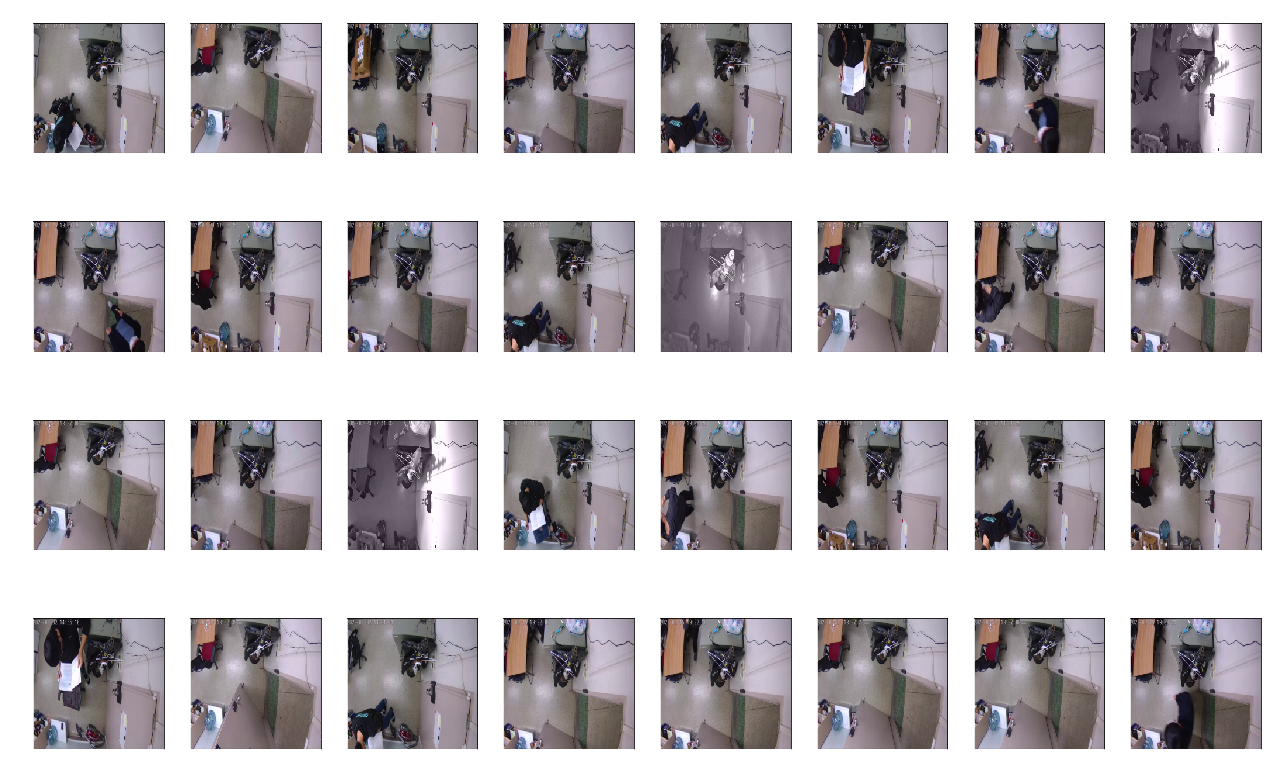

In [43]:
test_sample = next(iter(img_handler.test_ds))
show_images(test_sample[0][0:32], test_sample[1][0:32], nrows=4, ncols=8)

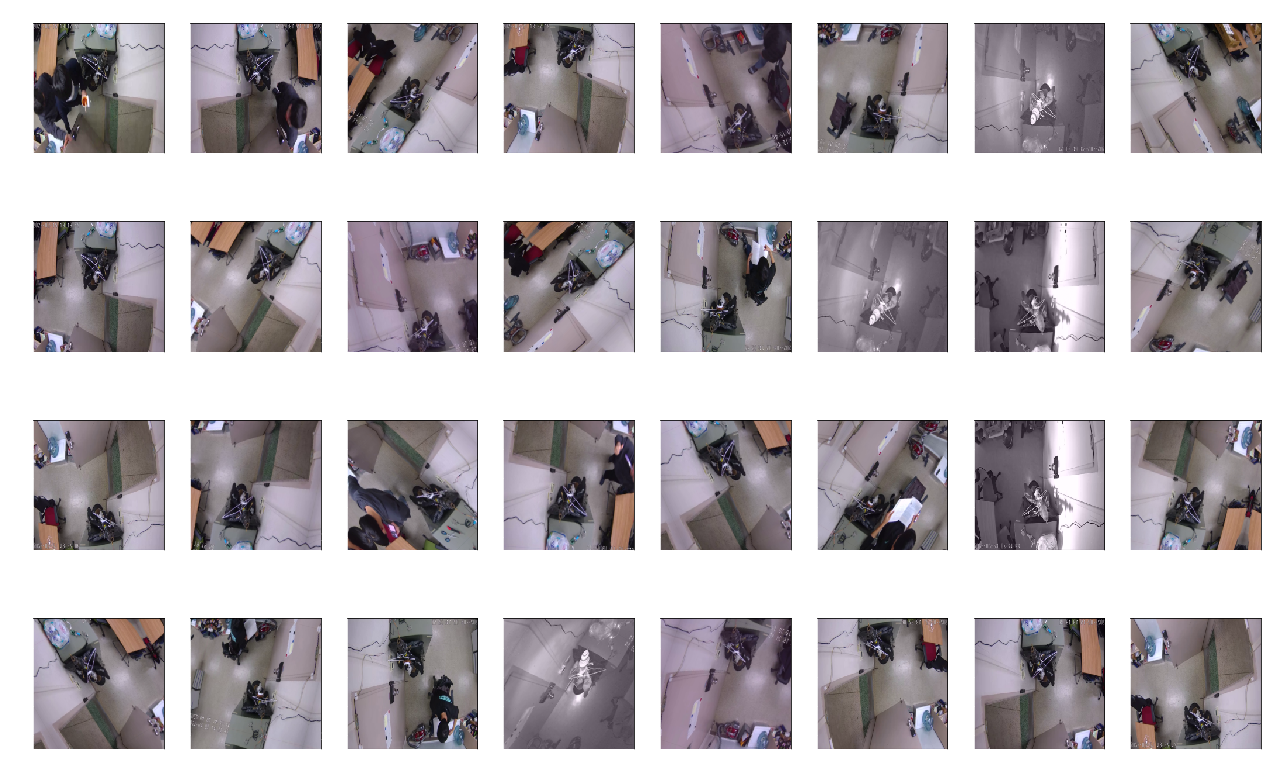

In [44]:
train_sample = img_handler.train_ds[0]
show_images(train_sample[0][0:32], train_sample[1][0:32], nrows=4, ncols=8)

In [32]:
model.evaluate(img_handler.test_ds)

2022-04-11 11:27:23.348191: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


16/16 [==============================] - 23s 1s/step - loss: 9.2570e-04 - accuracy: 1.0000


[0.0009066267521120608, 1.0]

In [34]:
model.predict(test_sample[0])

array([[3.6618114e-04, 9.9919748e-01],
       [9.9999797e-01, 5.4366742e-06],
       [4.3335259e-03, 9.9476856e-01],
       [9.9998963e-01, 2.4633824e-05],
       [4.1520596e-04, 9.9911904e-01],
       [2.2768676e-03, 9.9601996e-01],
       [9.9999493e-01, 1.2585242e-05],
       [5.0641170e-06, 9.9997580e-01],
       [9.9994648e-01, 1.2170502e-04],
       [1.1074543e-03, 9.9809861e-01],
       [9.9999410e-01, 1.4327308e-05],
       [3.0925870e-04, 9.9932098e-01],
       [1.3959825e-05, 9.9994212e-01],
       [9.9999833e-01, 4.5830138e-06],
       [1.0000000e+00, 4.1620768e-07],
       [9.9999774e-01, 5.8569749e-06],
       [9.9999821e-01, 4.6128575e-06],
       [9.9999344e-01, 1.6083712e-05],
       [5.2724617e-06, 9.9997497e-01],
       [4.3421984e-04, 9.9905610e-01],
       [1.0000000e+00, 3.4861722e-07],
       [1.2213886e-03, 9.9795622e-01],
       [4.2444468e-04, 9.9910414e-01],
       [1.0074973e-03, 9.9823660e-01],
       [2.1903217e-03, 9.9615133e-01],
       [9.9999976e-01, 8.